In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder


In [4]:
data_dir = '/content/drive/MyDrive/images'  # Update if needed
image_size = (224, 224)
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

generator = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False  # important for label alignment
)


Found 3171 images belonging to 4 classes.


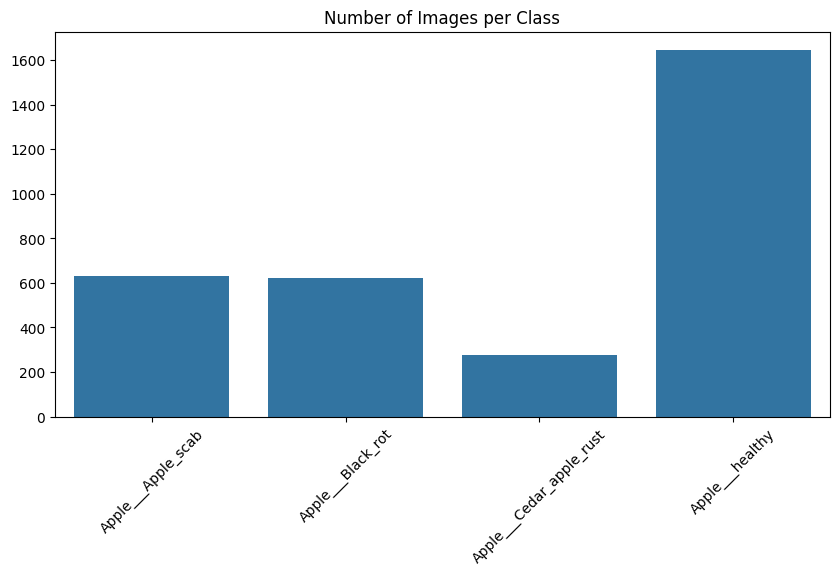

In [5]:
class_counts = {k: 0 for k in generator.class_indices}
for cls in generator.filenames:
    label = cls.split('/')[0]
    class_counts[label] += 1

plt.figure(figsize=(10,5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title('Number of Images per Class')
plt.xticks(rotation=45)
plt.show()


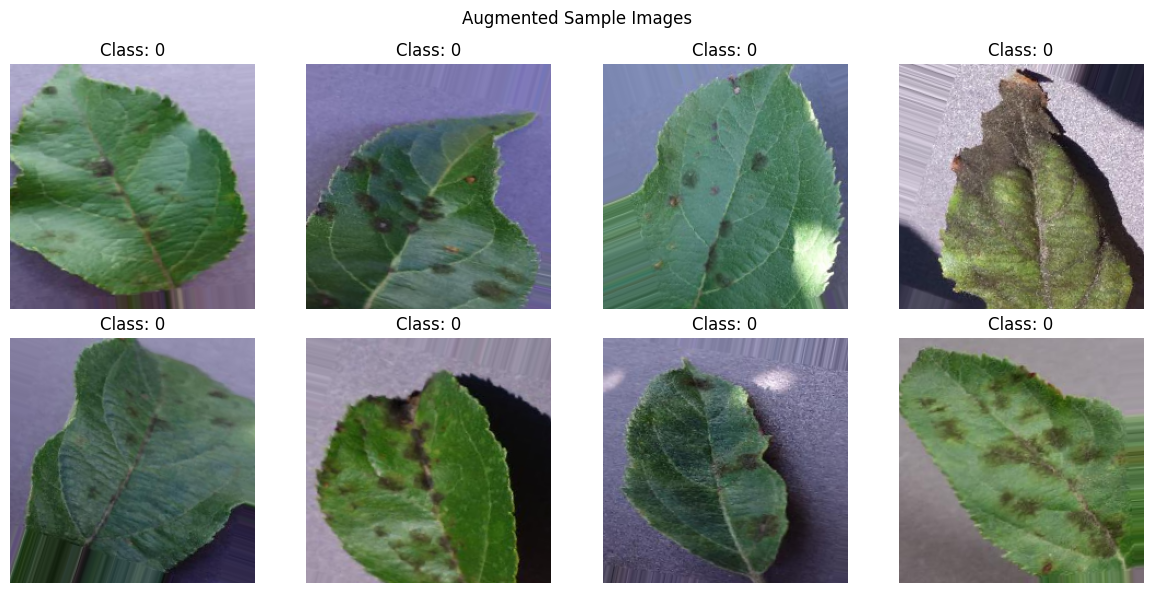

In [6]:
x_batch, y_batch = next(generator)

plt.figure(figsize=(12,6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(x_batch[i])
    plt.title(f"Class: {int(y_batch[i])}")
    plt.axis('off')
plt.suptitle("Augmented Sample Images")
plt.tight_layout()
plt.show()


Found 3171 images belonging to 4 classes.


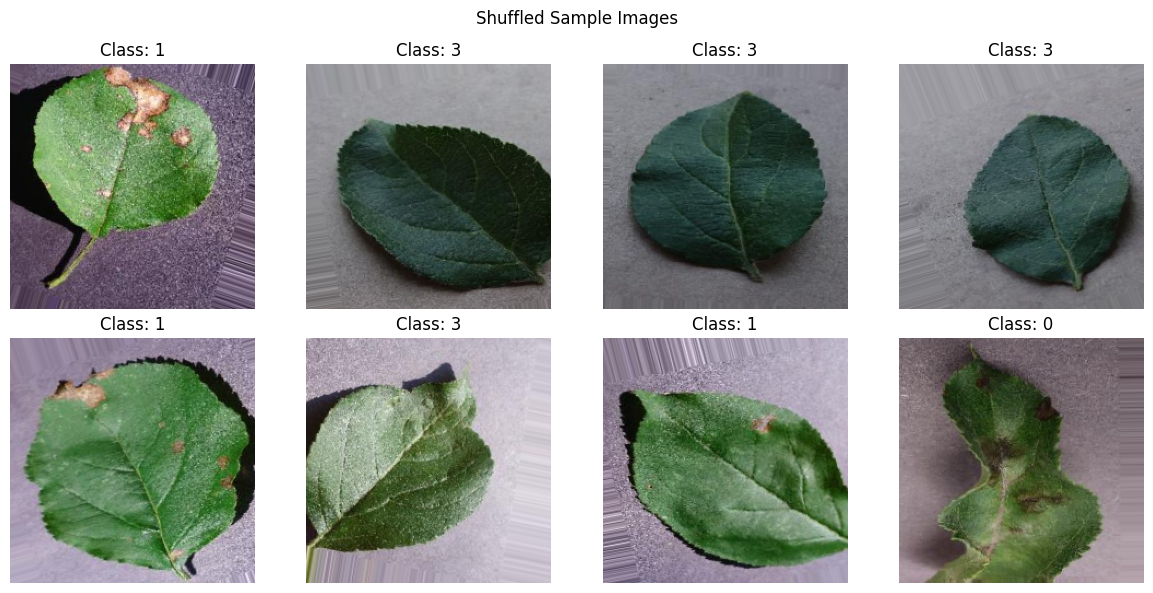

In [8]:
# prompt: shuffle images

import matplotlib.pyplot as plt
# Recreate the generator with shuffle=True
generator = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True  # Set shuffle to True
)

# Get a batch of shuffled images and display some
x_batch_shuffled, y_batch_shuffled = next(generator)

plt.figure(figsize=(12,6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(x_batch_shuffled[i])
    # Note: With shuffle=True, the order of images in x_batch and y_batch
    # will be random within the batch. The class labels still correspond
    # to the displayed images.
    plt.title(f"Class: {int(y_batch_shuffled[i])}")
    plt.axis('off')
plt.suptitle("Shuffled Sample Images")
plt.tight_layout()
plt.show()

In [11]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, pooling='avg')
model = Model(inputs=base_model.input, outputs=base_model.output)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
features = []
labels = []

# Total batches to extract features
steps = generator.samples // generator.batch_size + 1

# Define and load the pre-trained EfficientNetB0 model
# Include top=False to remove the classification layer

generator.reset()
for _ in tqdm(range(steps), desc="Extracting Features"):
    x_batch_shuffled, y_batch_shuffled = next(generator)
    # Preprocess the input images for the EfficientNetB0 model
    # Undo the initial rescaling by multiplying by 255.0
    # Then apply the model's specific preprocessing
    x_batch = preprocess_input(x_batch_shuffled * 255.0)
    feat_batch = model.predict(x_batch, verbose=0) # Use the preprocessed batch for prediction
    features.append(feat_batch)
    labels.extend(y_batch_shuffled) # Extend with y_batch_shuffled as this is the generator being used

features = np.vstack(features)
labels = np.array(labels)

Extracting Features: 100%|██████████| 100/100 [13:14<00:00,  7.95s/it]


In [13]:
le = LabelEncoder()
encoded_labels = le.fit_transform(labels.astype(int))

# Save to disk
np.save('/content/drive/MyDrive/apple_features.npy', features)
np.save('/content/drive/MyDrive/apple_labels.npy', encoded_labels)
np.save('/content/drive/MyDrive/apple_label_classes.npy', le.classes_)

print("Feature shape:", features.shape)
print("Labels shape:", encoded_labels.shape)
print("Label classes:", le.classes_)


Feature shape: (3171, 1280)
Labels shape: (3171,)
Label classes: [0 1 2 3]
